# Assignment 1: CS583
### Name: Dhruv Vaghela
### CWID: 20015603

### Imports and util fetch function to pull data

In [1]:
import tensorflow as tf
import os
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import L2

%matplotlib inline

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

### Fetching data and one-hot encoding labels

In [2]:
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Normalize train and test sets

In [3]:
image_size = X_train.shape[1]
input_size = image_size * image_size

X_train = np.reshape(X_train, [-1, input_size])
X_train = X_train.astype('float32') / 255
X_test = np.reshape(X_test, [-1, input_size])
X_test = X_test.astype('float32') / 255

## MNIST class and it's config

In [4]:
class MNIST:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = None
        self.image_size = 28
        self.input_size = self.image_size * self.image_size
        self.hidden_units = 500
        self.classes = 10
        self.bs = 64
        self.epochs = 250
        self.val_split = 0.2

    def train(self):
        return self.model.fit(self.X_train, self.y_train, batch_size=self.bs, epochs=self.epochs, validation_split=self.val_split)
        

    def evaluate(self):
        loss, acc = self.model.evaluate(self.X_test, self.y_test, batch_size=self.bs)
        return loss, acc
        

    def prepare_model(self, get_summary=False, regularizer=False, dropout=False):
        self.model = Sequential(name='MNIST')
        self.model.add(Dense(units=self.hidden_units, name='hidden_layer_1', activation='sigmoid', input_dim=self.input_size, kernel_regularizer=L2(0.01) if regularizer else None))
        if dropout:
            self.model.add(Dropout(0.2))
        self.model.add(Dense(units=self.hidden_units, name='hidden_layer_2', activation='sigmoid'))
        if dropout:
            self.model.add(Dropout(0.2))
        self.model.add(Dense(units=self.classes, name='output_layer', activation='softmax'))
        
        self.model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        if get_summary:
            self.model.summary()
        
        return self.model

In [5]:
mnist = MNIST(X_train, y_train, X_test, y_test)
model = mnist.prepare_model(regularizer=False)
h = mnist.train()

Epoch 1/250


2022-11-11 21:41:53.109957: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


750/750 [==============================] - 3s 3ms/step - loss: 2.2472 - accuracy: 0.2269 - val_loss: 2.1775 - val_accuracy: 0.2756
Epoch 2/250
750/750 [==============================] - 2s 3ms/step - loss: 2.0929 - accuracy: 0.4689 - val_loss: 1.9757 - val_accuracy: 0.6274
Epoch 3/250
750/750 [==============================] - 2s 3ms/step - loss: 1.8202 - accuracy: 0.6219 - val_loss: 1.6232 - val_accuracy: 0.6632
Epoch 4/250
750/750 [==============================] - 2s 3ms/step - loss: 1.4363 - accuracy: 0.7019 - val_loss: 1.2310 - val_accuracy: 0.7212
Epoch 5/250
750/750 [==============================] - 3s 4ms/step - loss: 1.1084 - accuracy: 0.7600 - val_loss: 0.9581 - val_accuracy: 0.7898
Epoch 6/250
750/750 [==============================] - 2s 3ms/step - loss: 0.8939 - accuracy: 0.7954 - val_loss: 0.7850 - val_accuracy: 0.8247
Epoch 7/250
750/750 [==============================] - 2s 3ms/step - loss: 0.7572 - accuracy: 0.8173 - val_loss: 0.6759 - val_accuracy: 0.8424
Epoch 8/250

## Evaluation of MNIST Model

In [6]:
model.save('./model.h5')


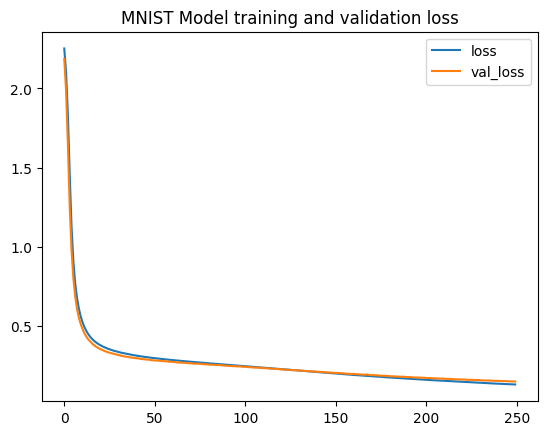

In [159]:
plt.plot(np.arange(250), h.history['loss'], label='loss')
plt.plot(np.arange(250), h.history['val_loss'], label='val_loss')
plt.title('MNIST Model training and validation loss')
plt.legend()
plt.show()

## Accuracy and Test Loss

In [161]:
loss, acc = mnist.evaluate()
print(f'Test Loss: {loss: .2f}')
print(f'Test Accuracy: {acc * 100: .2f}%')

157/157 [==============================] - 0s 1ms/step - loss: 0.1438 - accuracy: 0.9578
Test Loss:  0.14
Test Accuracy:  95.78%


## MNIST Model with L2 regularization and dropout

In [162]:
mnist_l2 = MNIST(X_train, y_train, X_test, y_test)
mnist_l2.prepare_model(get_summary=True, regularizer=True, dropout=True)
h_l2 = mnist_l2.train()

Model: "MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 500)               392500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 500)               250500    
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 output_layer (Dense)        (None, 10)                5010      
                                                                 
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
750/750 [==============================] - 

## Evaluation of MNIST Model with L2 Regularization and Dropout

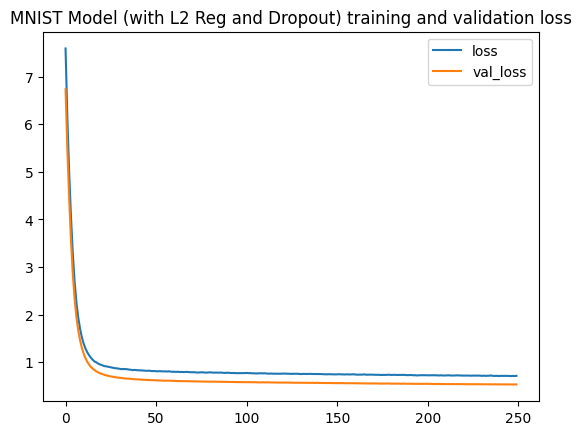

In [163]:
plt.plot(np.arange(250), h_l2.history['loss'], label='loss')
plt.plot(np.arange(250), h_l2.history['val_loss'], label='val_loss')
plt.title('MNIST Model (with L2 Reg and Dropout) training and validation loss')
plt.legend()
plt.show()

In [164]:
lloss, aacc = mnist_l2.evaluate()
print(f'Test Loss: {lloss: .2f}')
print(f'Test Accuracy: {aacc * 100: .2f}%')

157/157 [==============================] - 0s 1ms/step - loss: 0.5372 - accuracy: 0.9009
Test Loss:  0.54
Test Accuracy:  90.09%
